# Exploring Data

All our data is in subfolders. We can glob to get the list of all CSVs.

In [2]:
from glob import glob

files = glob("**/*.csv", recursive=True)
len(files)

28

We need to confirm that each file is infact a CSV.

In [3]:
import csv
import pandas

csv_files = []

for file_name in files:
    try:
        dframe = pandas.read_csv(file_name, nrows=3)
    except Exception as fail:
        print(file_name, fail)
    else:
        csv_files.append(file_name)

len(csv_files)

28

Using `pandas` we can take a small peek at our data.

In [4]:
import pandas, IPython

for fn in csv_files[:5]:
    dframe = pandas.read_csv(fn, nrows=3, skipinitialspace=True)
    print(fn)
    IPython.display.display(dframe)

0dd8408f-64c6-4d10-813f-b1dc66e50cfd/05to12_Iquery_Mumps_Data.csv


,Disease,YearText,Year,StateOrCounty,IL,Race,Ethnicity,Gender,AgeGroupText,AgeGroup,Count
0,Mumps,Year,2005,S,IL,Other,NotHispNotLatino,Female,CD5yr,10-14 Years,1
1,Mumps,Year,2005,S,IL,Other,UnkwnNotClassified,Male,CD5yr,0-4 Years,1
2,Mumps,Year,2005,S,IL,Unknown,Hispanic or Latino,Female,CD5yr,0-4 Years,1


16c5013f-fe84-45f5-a3e5-ce3301348f31/05to12_Iquery_Lyme_Data.csv


,Disease,YearText,Year,StateOrCounty,IL,Race,Ethnicity,Gender,AgeGroupText,AgeGroup,Count
0,Lyme Disease,Year,2011,S,IL,Unknown,UnkwnNotClassified,Male,CD5yr,50-54 Years,1
1,Lyme Disease,Year,2011,S,IL,Unknown,UnkwnNotClassified,Male,CD5yr,55-59 Years,5
2,Lyme Disease,Year,2011,S,IL,Unknown,UnkwnNotClassified,Male,CD5yr,5-9 Years,1


1ff5eab4-01be-4e9e-b9a2-f9147742cd49/05to12_Iquery_Leg_Data.csv


,Disease,YearText,Year,StateOrCounty,IL,Race,Ethnicity,Gender,AgeGroupText,AgeGroup,Count
0,Legionellosis,Year,2005,S,IL,Asian,NotHispNotLatino,Male,CD5yr,50-54 Years,1
1,Legionellosis,Year,2005,S,IL,BlackAfricanAmer,NotHispNotLatino,Female,CD5yr,35-39 Years,1
2,Legionellosis,Year,2005,S,IL,BlackAfricanAmer,NotHispNotLatino,Female,CD5yr,40-44 Years,2


21a9f43a-bc0b-444e-86d8-0080fc18d109/blockgroups_1990.csv


,OBJECTID,the_geom,AREA,PERIMETER,BG022071_,BG022071_I,BLOCKGROUP,BKG_KEY,SQ_MILES,PERSONS,...,OCCUPIED,OWNER_OCC,RENTER_OCC,MDN_YEAR,MDN_VALUE,Z_HOUR_,ACRES,POP_ACRE,SHAPE_area,SHAPE_len
0,174,MULTIPOLYGON (((-90.10587700110895 29.98325199...,2.242630e+06,6407.09144,185,183,1,220710054001,0.080443,406,...,232,117,115,1940,68400,6,51.4837,7.89,2.242630e+06,6407.091789
1,175,MULTIPOLYGON (((-90.06367400149767 29.98315999...,7.629741e+05,5060.32451,186,184,1,220710030001,0.027368,504,...,194,108,86,1944,48300,0,17.5155,28.77,7.629741e+05,5060.324749
2,261,MULTIPOLYGON (((-90.06513500109153 29.97220400...,2.930926e+06,8807.50288,272,270,3,220710034003,0.105133,1451,...,627,158,469,1939,51000,19,67.2848,21.57,2.930926e+06,8807.503012


2e462d97-9b25-43a8-b5f2-11dd3d7c8158/1995_Street_Tree_Census.csv


,RecordId,Address,House_Number,Street,Zip_Original,CB_Original,Site,Species,Diameter,Condition,...,Latitude,CB_New,Zip_New,CensusTract_2010,CensusBlock_2010,NTA_2010,SegmentID,Spc_Common,Spc_Latin,Location
0,1,245 E 17 ST,245,E 17 ST,10003,106,Front,PLAC,8,Unknown,...,40.734551,106,10003,48,2000,MN21,33134,LONDON PLANETREE,PLATANUS ACERIFOLIA,"(40.734551, -73.984235)"
1,2,80 N MOORE ST,80,N MOORE ST,10013,101,Side,ACPL,7,Good,...,40.720159,101,10013,39,2001,MN24,31567,"MAPLE, NORWAY",ACER PLATANOIDES,"(40.720159, -74.010532)"
2,3,80 N MOORE ST,80,N MOORE ST,10013,101,Side,ACPL,6,Good,...,40.720159,101,10013,39,2001,MN24,31567,"MAPLE, NORWAY",ACER PLATANOIDES,"(40.720159, -74.010532)"


Pandas does a pretty good job on detecting column types but it isn't perfect. Monetary values and geospatial types are not automatically handled. Below is some code to fill the gaps with a `detect_converter` method.

In [5]:
import os, csv


ANNOTATION_TYPES = {
    'str': 'String',
    'decimal': 'Decimal/Number/Floats',
    'money': 'Money',
    'int': 'Integer',
    'geometry': 'Geometries and Polygons',
    'percentage': 'Percentage %',
    'latlong': 'Lat & Long',
    'date': 'Date',
    'timestamp': 'Timestamp',
}

from decimal import Decimal
import numpy
import pandas
from functools import partial
from geopandas import GeoSeries
from shapely.geometry import shape
import re


def allowEmpty(f, emptyValue=None):
    def doit(value):
        if isinstance(value, str):
            value = value.strip()
        if not value:
            return emptyValue
        return f(value)
    return doit

allowNaN = partial(allowEmpty, emptyValue=numpy.nan)

def parseTuple(value):
    value = value.strip().replace('(', '').replace(')', '')
    if ',' not in value:
        raise TypeError
    return [v.strip() for v in value.split(',')]


geometry_matcher = re.compile("(?P<type>[\w]+) \((?P<points>[\d,\s\.\-\(\)]+)\)")
def parseGeometry(value):
    #return shape after formating as geojson
    #TYPE (((lat long, lat long, ...)))
    match = geometry_matcher.match(value)
    if not match:
        raise TypeError
    coords = []
    depth = 0
    geometry = {
        'type': match.group('type'),
        'coordinates': coords,
    }
    
    def cur_position():
        cur = coords
        for i in range(depth):
            cur = cur[-1]
        return cur
    
    point_chunks = (chunk.strip() for chunk in match.group('points').split(','))
    for chunk in point_chunks:
        while chunk[0] == '(':
            cur_position().append([])
            depth +=1
            chunk = chunk[1:]
        next_depth = depth
        while chunk[-1] == ')':
            next_depth -=1
            chunk = chunk[:-1]
        assert depth > -1
        points = tuple(Decimal(point.strip()) for point in chunk.split() if chunk)
        if points:
            cur_position().append(tuple(points))
        depth = next_depth
    return shape(geometry)

#assert GeoSeries(parseGeometry("MULTIPOLYGON (((125 -931, 506.3 -293.2, 506.3 -293.2)))")).to_json() == \
#'''{"features": [{"properties": {}, "bbox": [125.0, -931.0, 506.3, -293.2], "id": "0", "geometry": {"coordinates": [[[[125.0, -931.0], [506.3, -293.2], [506.3, -293.2], [125.0, -931.0]]]], "type": "MultiPolygon"}, "type": "Feature"}], "bbox": [125.0, -931.0, 506.3, -293.2], "type": "FeatureCollection"}'''

def parsePercentage(value):
    value = value.strip()
    if not value.endswith('%'):
        raise TypeError
    return Decimal(value[:-1])/100
assert parsePercentage("5%") == Decimal(".05")

#more like parse USD
def parseMoney(value):
    value = value.strip()
    if not value.startswith('$'):
        raise TypeError
    return Decimal(value[1:])
assert parseMoney("$5.00") == Decimal("5.00")

def parseTimeStamp(value):
    value = value.strip()
    if ' ' not in value and ':' not in value:
        raise TypeError
    return pandas.to_datetime(value, infer_datetime_format=True)

ANNOTATION_CONVERTERS = {
    'str': str,
    'decimal': lambda x: Decimal(x.replace(',','')),
    'money': parseMoney,
    'int': lambda x: int(x.replace(',','')),
    'geometry': parseGeometry,
    'percentage': parsePercentage,
    'latlong': lambda x: [Decimal(value) for value in parseTuple(x)],
    'date': partial(pandas.to_datetime, infer_datetime_format=True),
    'timestamp': parseTimeStamp,
}

def pass_or_fail(f):
    def doit(val):
        try:
            f(val)
        except:
            return False
        else:
            return True
    return doit

ANNOTATION_VALIDATORS = {ctype:pass_or_fail(conv) for ctype, conv in ANNOTATION_CONVERTERS.items()}

def detect_converter(fn):
    opened_csv = pandas.read_csv(fn, skipinitialspace=True, nrows=2)
    mapping = dict()
    for column in opened_csv:
        dtype = opened_csv.dtypes[column]
        if dtype == numpy.object: 
            if not len(opened_csv[column]): continue #no rows
            value = opened_csv[column][0]
            matches = {ctype for ctype, validator in ANNOTATION_VALIDATORS.items() if validator(value)}
            if len(matches) == 1:
                ctype = list(matches)[0]
            elif len(matches) == 2:
                matches.remove('str')
                ctype = list(matches)[0]
            #int is the most specific...
            elif 'int' in matches:
                ctype = 'int'
            elif matches == {'date', 'str', 'timestamp'}:
                ctype = 'timestamp'
            elif matches == {'date', 'str', 'decimal'}:
                ctype = 'decimal'
            else:
                print("Column Label:", column)
                print("Column Sample:", value)
                print("Matches:", matches)
                while True:
                    ctype = input("? ").lower()
                    if ctype in short_options:
                        ctype = short_options[ctype]
                    if ctype not in ANNOTATION_TYPES:
                        print("Not a valid option", ctype, short_options.keys())
                    else:
                        break
            ctype = ANNOTATION_CONVERTERS[ctype]
        else:
            ctype = dtype #already classified
        #print(column, '->', ctype)
        mapping[column] = ctype
    return mapping

Let's take a look at a file with geospatial data and how we can display the data using `geopandas`.

In [6]:
interesting_file = "21a9f43a-bc0b-444e-86d8-0080fc18d109/blockgroups_1990.csv"

import geopandas, pandas, matplotlib


data_frame = pandas.read_csv(interesting_file, skipinitialspace=True, converters=detect_converter(interesting_file))
data_frame = data_frame[data_frame['PERSONS'] > 0]
geo_data_frame = geopandas.GeoDataFrame(data=data_frame, geometry='the_geom')
#geo_data_frame.merge(data_frame)
#type(data_frame['the_geom'][1])

geo_data_frame

,OBJECTID,the_geom,AREA,PERIMETER,BG022071_,BG022071_I,BLOCKGROUP,BKG_KEY,SQ_MILES,PERSONS,...,OCCUPIED,OWNER_OCC,RENTER_OCC,MDN_YEAR,MDN_VALUE,Z_HOUR_,ACRES,POP_ACRE,SHAPE_area,SHAPE_len
0,174,(POLYGON ((-90.10587700110895 29.9832519999427...,2.242630e+06,6407.09144,185,183,1.0,220710054001,0.080443,406,...,232,117,115,1940,68400,6,51.4837,7.89,2.242630e+06,6407.091789
1,175,(POLYGON ((-90.06367400149767 29.9831599999884...,7.629741e+05,5060.32451,186,184,1.0,220710030001,0.027368,504,...,194,108,86,1944,48300,0,17.5155,28.77,7.629741e+05,5060.324749
2,261,(POLYGON ((-90.06513500109153 29.9722040002119...,2.930926e+06,8807.50288,272,270,3.0,220710034003,0.105133,1451,...,627,158,469,1939,51000,19,67.2848,21.57,2.930926e+06,8807.503012
3,262,(POLYGON ((-90.00904300099363 29.9725869999028...,9.052184e+05,3933.94151,273,271,3.0,220710009023,0.032470,379,...,130,74,56,1965,19800,39,20.7810,18.24,9.052185e+05,3933.941705
4,263,(POLYGON ((-90.09120100116085 29.9724229999437...,1.735403e+06,5299.15568,274,272,3.0,220710050003,0.062249,645,...,263,47,216,1939,49800,33,39.8394,16.19,1.735403e+06,5299.155684
5,264,(POLYGON ((-90.01802600128185 29.9724100001414...,1.757262e+06,5337.26862,275,273,5.0,220710009035,0.063033,829,...,273,145,128,1957,44800,29,40.3412,20.55,1.757262e+06,5337.268752
6,265,(POLYGON ((-90.03684800137535 29.9723079998617...,1.612407e+06,5656.14979,276,274,1.0,220710013021,0.057837,967,...,313,157,156,1950,52800,22,37.0158,26.12,1.612407e+06,5656.149787
7,266,(POLYGON ((-90.07103300145944 29.9710589995692...,1.096485e+06,5082.67477,277,275,2.0,220710040002,0.039331,551,...,248,80,168,1939,77400,10,25.1718,21.89,1.096485e+06,5082.674785
8,267,(POLYGON ((-90.10915600102075 29.9720819997141...,2.876913e+06,8120.96086,278,276,4.0,220710071004,0.103195,100,...,51,9,42,1956,24500,0,66.0448,1.51,2.876913e+06,8120.960561
9,240,(POLYGON ((-90.10530500125418 29.9735869995781...,2.017431e+06,5733.71369,251,249,4.0,220710065004,0.072365,1147,...,471,154,317,1939,47500,66,46.3138,24.77,2.017431e+06,5733.713923


We can plot the geometries using matplotlib:

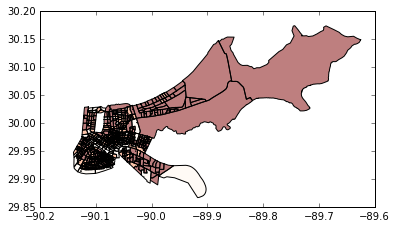

In [7]:
%matplotlib inline

geo_data_frame.plot(column='PERSONS', scheme='QUANTILES', k=3, cmap='OrRd')

Computing the centroid of all the geometries can be useful for interactive maps

In [8]:
from shapely.geometry import MultiPoint

print(geo_data_frame.centroid)
#print(geo_data_frame['the_geom'][1])
centroid = MultiPoint(geo_data_frame.centroid).centroid

center = centroid.x, centroid.y
zoom = 10

center

0      POINT (-90.10690643186619 29.98126934231104)
1      POINT (-90.06136716822475 29.98281639615198)
2       POINT (-90.06615682011352 29.9694888027856)
3      POINT (-90.00763356897961 29.97098707726466)
4      POINT (-90.09078316607972 29.96990584164759)
5      POINT (-90.01626941820118 29.97032626286058)
6      POINT (-90.03406671123987 29.97053208760881)
7      POINT (-90.07115187828822 29.97008246403694)
8       POINT (-90.1064212197026 29.96843817547813)
9      POINT (-90.10605626010222 29.97208077221727)
10      POINT (-90.0068260323272 29.97295703119571)
11     POINT (-90.06061906474193 29.97349853397365)
12     POINT (-90.01110001183761 29.97247897397992)
13     POINT (-90.08282719489846 29.97227611662639)
14     POINT (-90.07723230406458 29.97183967560807)
15     POINT (-90.06760884926152 29.97250880032188)
16     POINT (-90.10059100647609 29.97218470877428)
17     POINT (-90.04200115097767 29.97189704205118)
18     POINT (-90.05032408216957 29.97187210583816)
19     POINT

KeyError: 109

Can also draw using `ipyleaflet`

In [9]:
from ipyleaflet import GeoJSON, Map, TileLayer, DrawControl
import json


m = Map(default_tiles=TileLayer(opacity=1.0))#, center=center, zoom=zoom)
data = json.loads(geo_data_frame.to_json())

g = GeoJSON(data=data)
m.add_layer(g)

m

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [10]:
feature = 'PERSONS'

import folium
map_osm = folium.Map()#location=center)
min_feature = min(data_frame[feature])
max_feature = max(data_frame[feature])
threshold_scale = list(range(min_feature, max_feature, int((max_feature-min_feature)/6)))[:6]
assert len(threshold_scale) == 6
map_osm.choropleth(data=data_frame, geo_str=geo_data_frame.to_json(),
     columns=['OBJECTID', feature],
     #threshold_scale=threshold_scale,
     key_on='feature.properties.OBJECTID',
     fill_color='BuPu', fill_opacity=0.7, line_opacity=0.5,
     legend_name='Population')
map_osm

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
